In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import missingno as msno # installed using: `pip install missingno`
import numpy.ma as ma
from itertools import groupby
import datetime
from datetime import datetime
from scipy.signal import savgol_filter
from scipy.interpolate import PchipInterpolator
from matplotlib.gridspec import GridSpec
import csv
import re

In [64]:
# load data
tower_dfs_15m = []
tower_dfs_60m = []
towers_of_interest = ['TOWA', 'TOWB', 'TOWD', 'TOWF', 'TOWS', 'TOWY']

# populate df lists
for tower in towers_of_interest:

    print(tower)
    
    #15-minute data
    df_15m = pd.read_csv(f'../data/met_towers_2017-2022_final-qa/{tower}_2017-2022_final-qa.csv',
                         header=0, na_values=['-999.0', '#DIV/0!', -999], parse_dates=True)
    df_15m = df_15m.drop('ET_timestamp', axis=1)
    df_15m['UTC_timestamp'] = pd.to_datetime(df_15m['UTC_timestamp'], format='%Y%m%d%H%M%S')
    df_15m = df_15m.set_index('UTC_timestamp', drop=True)
    df_15m.index = df_15m.index.tz_localize('UTC')
    df_15m = df_15m.asfreq('15min')
    
    # 60-minute data
    df_60m = pd.read_csv(f'../data/met_towers_2017-2022_hourly-qa/{tower}_2017-2022_hourly-qa.csv',
                         index_col=0, header=0, na_values=['-999.0', '#DIV/0!', -999])
    tower_dfs_15m.append(df_15m)
    tower_dfs_60m.append(df_60m)

TOWA
TOWB
TOWD
TOWF
TOWS
TOWY


## 1. Fill gaps with hourly data

In [65]:
# loop through four 15-min dataframes, 60-min dataframes, and tower names
tdfs_15m_gapfilled = []
for i, (df_15m, df_60m, tname) in enumerate(zip(tower_dfs_15m, tower_dfs_60m, towers_of_interest)):

    print(tname)

    # match index datatypes
    df_15m.index = pd.to_datetime(df_15m.index)
    df_60m.index = pd.to_datetime(df_60m.index)

    # empty list to be filled with gap-filled columns
    gap_filled_cols = []
    
    ##################################################################
    # find consecutive gaps in each column
    ##################################################################

    # get missing time periods
    for col_name in df_15m.columns.to_list():

        length = []
        dstart = []
        dend = []
        idxs = []
        
        # print(f'{tname}: {col_name}')
        missing_data = df_15m[col_name].isnull()
        consecutive_missing = []
        for column, g in groupby(enumerate(missing_data), lambda x: x[1]):
            if column:
                consecutive_missing.append(list(map(lambda x: x[0], list(g))))
    
        # save missing time periods
        for lst in consecutive_missing:
    
            # gaps in time
            steps = len(lst)
            mins = steps*15
            hours = mins/60
            start = lst[0]
            end = lst[-1]
    
            # append gap lengths, start of gap, end of gap, idxs
            length.append(hours)
            dstart.append(df_15m.iloc[start,:].name)
            dend.append(df_15m.iloc[end,:].name)
            idxs.append(lst)
    
        ##################################################################
        # gap-fill each column
        ##################################################################
        
        # create dataframe of missing data
        missing_data = pd.DataFrame(length, columns=['gap_length_hrs'])
        missing_data['tower'] = tname
        missing_data['colname'] = col_name
        missing_data['gap_start_date'] = dstart
        missing_data['gap_end_date'] = dend
        missing_data['indexes'] = idxs
    
        # group gaps into gap types: small, medium, large
        mid_gaps = missing_data[(missing_data['gap_length_hrs'] >= 3) & (missing_data['gap_length_hrs'] <= 6)]
        big_gaps = missing_data[missing_data['gap_length_hrs'] > 6]
        sml_gaps = missing_data[missing_data['gap_length_hrs'] < 3]

        #-----------------------------------------------------------------#
        # (1) fill gaps with hourly data
        main_gaps = pd.concat([sml_gaps, mid_gaps, big_gaps])
        
        # flatten 2D list of NaN indices
        idx_lst = main_gaps['indexes'].to_list()
        idx_lst = [x for lst in idx_lst for x in lst]

        # subselect dataframe to current column
        df_15m_col = df_15m[[col_name]]
        try:
            df_60m_col = df_60m[[col_name]]
        except Exception as e:
            # print(f'**ERROR** No 60-min column {col_name}')
            pass

        # fill gaps with hourly data
        try:
            df_60m_sel = df_60m_col.iloc[idx_lst]
            df_15m_col = df_15m_col.fillna(df_60m_sel) # filling gaps with hourly
        except Exception as e:
            # print(f'**UNKNOWN INDEX ERROR** for {col_name}')
            pass

        gap_filled_cols.append(df_15m_col)

    # concatenate filled columns column-wise (axis=1)
    new_df = pd.concat(gap_filled_cols, axis=1)
    tdfs_15m_gapfilled.append(new_df)

TOWA
TOWB
TOWD
TOWF
TOWS
TOWY


## 2. Fill small gaps with Linear and PCHIP interpolation
PCHIP performs visually better than plain linear interpolation; linear interpolation creates new outliers

In [66]:
# Add linear interpolation comparison
tdfs_15m_gapfilled_pchip = []
tdfs_15m_gapfilled_linear = []

def add_buffer(df_15m, col_name, buffer_hours=3):
    df_15m.index = pd.to_datetime(df_15m.index)
    mean_buffer = df_15m.groupby([df_15m.index.month, df_15m.index.day, df_15m.index.hour])[col_name].median()
    
    start_date = df_15m.index[0] - pd.Timedelta(hours=buffer_hours)
    start_buffer = [mean_buffer[(start_date.month, start_date.day, hour)] for hour in range(start_date.hour, start_date.hour + buffer_hours)]
    
    end_date = df_15m.index[-1] + pd.Timedelta(hours=buffer_hours)
    end_buffer = [mean_buffer[(end_date.month, end_date.day, hour)] for hour in range(end_date.hour - buffer_hours + 1, end_date.hour + 1)]
    
    buffer_start = pd.Series(start_buffer, index=pd.date_range(start=start_date, periods=buffer_hours, freq='h'))
    buffer_end = pd.Series(end_buffer, index=pd.date_range(start=df_15m.index[-1] + pd.Timedelta(hours=1), periods=buffer_hours, freq='h'))
    
    df_with_buffer = pd.concat([buffer_start, df_15m[col_name], buffer_end])
    
    return df_with_buffer

def rolling_clip(series, window=48, threshold=1.5):
    rolling_median = series.rolling(window=window, min_periods=1, center=True).median()
    rolling_std = series.rolling(window=window, min_periods=1, center=True).std()
    lower_bound = rolling_median - threshold * rolling_std
    upper_bound = rolling_median + threshold * rolling_std
    return series.clip(lower=lower_bound, upper=upper_bound)

def global_clip(series, lower_percentile=1, upper_percentile=99):
    lower_bound = series.quantile(lower_percentile / 100.0)
    upper_bound = series.quantile(upper_percentile / 100.0)
    return series.clip(lower=lower_bound, upper=upper_bound)

for i, (df_15m, tname) in enumerate(zip(tdfs_15m_gapfilled, towers_of_interest)):

    print(tname)
    gap_filled_cols_pchip = []
    gap_filled_cols_linear = []

    for col_name in df_15m.columns.to_list():
        
        df_15m_col = df_15m[[col_name]].copy()

        try:
            # Smooth the data before interpolation
            df_with_buffer = add_buffer(df_15m_col, col_name, buffer_hours=3)
            smoothed_col = savgol_filter(df_with_buffer.values, window_length=11, polyorder=2, mode='nearest')
            smoothed_df = pd.DataFrame(smoothed_col, index=df_with_buffer.index, columns=[col_name])

            # PCHIP interpolation
            smoothed_df_pchip = smoothed_df.copy()
            smoothed_df_pchip[col_name] = smoothed_df_pchip[col_name].interpolate(method='pchip', limit=12, limit_direction='both')
            smoothed_df_pchip[col_name] = global_clip(smoothed_df_pchip[col_name], lower_percentile=1, upper_percentile=99)
            smoothed_df_pchip[col_name] = rolling_clip(smoothed_df_pchip[col_name])
            df_15m_col[col_name] = df_15m_col[col_name].fillna(smoothed_df_pchip[col_name])
            gap_filled_cols_pchip.append(df_15m_col)

            # Linear interpolation
            df_15m_col_linear = df_15m[[col_name]].copy()
            smoothed_df_linear = smoothed_df.copy()
            smoothed_df_linear[col_name] = smoothed_df_linear[col_name].interpolate(method='linear', limit=12, limit_direction='both')
            smoothed_df_linear[col_name] = global_clip(smoothed_df_linear[col_name], lower_percentile=1, upper_percentile=99)
            smoothed_df_linear[col_name] = rolling_clip(smoothed_df_linear[col_name])
            df_15m_col_linear[col_name] = df_15m_col_linear[col_name].fillna(smoothed_df_linear[col_name])
            gap_filled_cols_linear.append(df_15m_col_linear)

        except Exception as e:
            print(f"Interpolation failed for {col_name}: {e}")
            pass

    new_df_pchip = pd.concat(gap_filled_cols_pchip, axis=1)
    tdfs_15m_gapfilled_pchip.append(new_df_pchip)

    new_df_linear = pd.concat(gap_filled_cols_linear, axis=1)
    tdfs_15m_gapfilled_linear.append(new_df_linear)

TOWA
TOWB
TOWD
TOWF
TOWS
TOWY


## 3. Visualize original vs gap-filled data using MSNO

In [67]:
# Define the column renaming guide
label_conversions = {
    'TempC': 'Temperature',
    'RelHum': 'Relative Humidity',
    'AbsHum': 'Absolute Humidity',
    'WSpdMph': 'Lateral Wind Speed',
    'PkWSpdMph': 'Peak Lateral Wind Speed',
    'VSSpdMph': 'Vertical Wind Speed',
    'BarPresMb': 'Pressure',
    'Sigma': 'Directional Wind Shear',
    'SigPhi': 'Vertical Wind Shear',
    'WDir': 'Wind Direction',
    'PrecipIn': 'Precipitation'
}

In [73]:
# Function to rename columns based on the guide and remove leading zeros in height
def rename_columns(df, conversions):
    # For each column, check if it matches a pattern and rename accordingly
    renamed_columns = {}
    for col in df.columns:
        new_name = col
        for key, value in conversions.items():
            if key in col:  # Check for a match
                # Extract measurement height if present (e.g., _015m)
                if "_" in col:
                    parts = col.split("_")
                    if len(parts) > 1 and parts[1].endswith("m"):
                        height = parts[1].lstrip("0")
                        height = re.sub(r"(\d+)m", r"\1-m", height)
                        new_name = f"{value} at {height}"
                    else:
                        new_name = value
                else:
                    new_name = value
        renamed_columns[col] = new_name
    
    # Return a new DataFrame with renamed columns
    return df.rename(columns=renamed_columns, inplace=False)

# Loop through pairs of dataframes and rename columns
renamed_dfs_15m = []  # List to store renamed DataFrames for tdf
renamed_dfs_15m_gf_linear = []  # List to store renamed DataFrames for tdf_gf
renamed_dfs_15m_gf_pchip = []

for tdf, tdf_gf_linear, tdf_gf_pchip in zip(tower_dfs_15m, tdfs_15m_gapfilled_linear, tdfs_15m_gapfilled_pchip):
    renamed_tdf = rename_columns(tdf, label_conversions)      # Get renamed DataFrame for tdf
    renamed_tdf_gf_linear = rename_columns(tdf_gf_linear, label_conversions)  # Get renamed DataFrame for tdf_gf
    renamed_tdf_gf_pchip = rename_columns(tdf_gf_pchip, label_conversions)
    
    # Add the renamed DataFrames to the lists
    renamed_dfs_15m.append(renamed_tdf)
    renamed_dfs_15m_gf_linear.append(renamed_tdf_gf_linear)
    renamed_dfs_15m_gf_pchip.append(renamed_tdf_gf_pchip)

In [74]:
def plot_missing_data_with_sparkline(data, ax_matrix, ax_sparkline, title):
    """Plot the missingno matrix and a custom sparkline for missing data."""
    # Plot missingno matrix
    msno.matrix(data, ax=ax_matrix, sparkline=False, fontsize=16, color=(0.5, 0.5, 0.5))
    # Adjust the title to be fully left-justified
    ax_matrix.set_title(title, fontsize=24, loc='left', x=-0.09)  # Use x=0.0 for full left alignment
    
    # Remove y-axis tick labels from the matrix plot
    y_positions = [-0.5, 35040, 70080, 105120, 140160, 175296, 210335.5]
    years = [2017, 2018, 2019, 2020, 2021, 2022, 2023]
    for tick, year in zip(y_positions, years):
        if year not in [2017, 2023]:
            ax_matrix.axhline(y=tick, c='black', ls='--', lw=1)
    ax_matrix.set_yticks(y_positions)
    ax_matrix.set_yticklabels(years) 
    
    # Calculate missing values per timestamp and plot as a sparkline
    missing_counts = data.isna().sum(axis=1)
    ax_sparkline.plot(missing_counts, missing_counts.index, color=(0.5, 0.7, 0.5))
    ax_sparkline.set_title('Missing Data Sparkline', fontsize=12)
    ax_sparkline.set_xlabel('Missing Count')
    ax_sparkline.set_ylim(missing_counts.index.min(), missing_counts.index.max())
    
    # Reverse the y-axis so the oldest year is at the top
    ax_sparkline.invert_yaxis()
    ax_sparkline.grid(axis='y', color='black', ls='--', lw=1)
    ax_sparkline.set_axisbelow(False)
    ax_sparkline.set_yticklabels([])

In [75]:
# Combined plot of non-gapfilled and gap-filled data
for tdf_15m, gapfilled_tdf, tname in zip(renamed_dfs_15m, renamed_dfs_15m_gf_linear, towers_of_interest):

    # Sort columns to ensure consistency between original and gap-filled data
    tdf_15m = tdf_15m[sorted(tdf_15m.columns)]
    gapfilled_tdf = gapfilled_tdf[sorted(gapfilled_tdf.columns)]

    # Create figure and GridSpec layout for 1 row and 4 columns
    fig = plt.figure(figsize=(12, 16))  # Adjust figure width for 4 subplots in a row
    gs = GridSpec(2, 2, width_ratios=[1, 0.3], wspace=0.1, hspace=1)  # Reduce space to make subplots closer

    # First pair: Original data
    ax_matrix_1 = fig.add_subplot(gs[0, 0])
    ax_sparkline_1 = fig.add_subplot(gs[0, 1])
    plot_missing_data_with_sparkline(tdf_15m, ax_matrix_1, ax_sparkline_1, f'(A) {tname} Original Data')

    # Second pair: Gap-filled data
    ax_matrix_2 = fig.add_subplot(gs[1, 0])
    ax_sparkline_2 = fig.add_subplot(gs[1, 1])
    plot_missing_data_with_sparkline(gapfilled_tdf, ax_matrix_2, ax_sparkline_2, f'(B) {tname} Gap-filled Data')

    # save figure
    save_path = f'../graphics/gapfilling/missing_data_plots/{tname}_2017–2022.png'
    directory = os.path.dirname(save_path)
    if not os.path.exists(directory):
        os.makedirs(directory)
    print(f'Saving image to {save_path}')
    fig.savefig(save_path, bbox_inches='tight')

    plt.close(fig)

Saving image to ../graphics/gapfilling/missing_data_plots/TOWA_2017–2022.png
Saving image to ../graphics/gapfilling/missing_data_plots/TOWB_2017–2022.png
Saving image to ../graphics/gapfilling/missing_data_plots/TOWD_2017–2022.png
Saving image to ../graphics/gapfilling/missing_data_plots/TOWF_2017–2022.png
Saving image to ../graphics/gapfilling/missing_data_plots/TOWS_2017–2022.png
Saving image to ../graphics/gapfilling/missing_data_plots/TOWY_2017–2022.png


## 4. Visualize raw timeseries to visually assess gap-filling performance

In [77]:
def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

# Path to the CSV file
csv_file_path = "../data/pchip_vs_linear_comparison.csv"

# Open the CSV file for writing
with open(csv_file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    # Write the header row
    writer.writerow(['tower', 'variable', 'height', 'pchip_rmse', 'linear_rmse'])

    for tdf_15m, tdf_15m_gapfilled_pchip, tdf_15m_gapfilled_linear, tower_name in zip(renamed_dfs_15m, renamed_dfs_15m_gf_pchip, renamed_dfs_15m_gf_linear, towers_of_interest):
        # Loop through each column in the dataframe
        for column in tdf_15m.columns:
            variable, height = column.split(' ')[0], column.split(' ')[-1].split('-')[0]

            # Generate a new random mask for each plot
            mask = np.random.choice([True, False], size=tdf_15m[column].shape, p=[0.8, 0.2])

            # Mask the test data by assigning NaNs (instead of dropping values)
            train_data = tdf_15m[column].copy()
            test_data = train_data[~mask]
            train_data[~mask] = np.nan  # Replace test data points with NaN in the training set

            # Ensure the index is monotonic for PCHIP
            train_data_sorted = train_data.sort_index()

            # Apply interpolation on the training set with masked NaNs
            pchip_filled = train_data_sorted.interpolate(method='pchip')
            linear_filled = train_data_sorted.interpolate(method='linear')

            # Ensure no NaNs in test_data and corresponding interpolated values
            test_data_nonan = test_data.dropna()
            pchip_filled_nonan = pchip_filled.loc[test_data_nonan.index].dropna()
            linear_filled_nonan = linear_filled.loc[test_data_nonan.index].dropna()

            # Ensure matching indices
            common_index = test_data_nonan.index.intersection(pchip_filled_nonan.index)

            # Align both datasets to this common index
            test_data_aligned = test_data_nonan.loc[common_index]
            pchip_filled_aligned = pchip_filled_nonan.loc[common_index]
            linear_filled_aligned = linear_filled_nonan.loc[common_index]

            # Calculate RMSE for PCHIP and Linear interpolation
            rmse_pchip = np.sqrt(mean_squared_error(test_data_aligned, pchip_filled_aligned))
            rmse_linear = np.sqrt(mean_squared_error(test_data_aligned, linear_filled_aligned))
            rmse_pchip_rounded = round(rmse_pchip, 4)
            rmse_linear_rounded = round(rmse_linear, 4)

            # Write the row to the CSV file
            writer.writerow([tower_name, variable, height, rmse_pchip_rounded, rmse_linear_rounded])

print(f"RMSE values written to {csv_file_path}")

RMSE values written to ../data/pchip_vs_linear_comparison.csv


## 4. Export gap-filled data

In [78]:
# export gap-filled data
for tdf, tower in zip(tdfs_15m_gapfilled_linear, towers_of_interest):
    tdf.to_csv(f'../data/met_towers_2017-2022_gapfilled-qa/{tower}_2017-2022_gapfilled-qa-2.csv')

In [79]:
# export boolean table
# Example table: was a value gap-filled? true = yes; false = no
((tower_dfs_15m[0].fillna(-999)).ne((tdfs_15m_gapfilled_linear[0].fillna(-999)))).head(5)
for df_orig, df_filled, tower in zip(tower_dfs_15m, tdfs_15m_gapfilled_linear, towers_of_interest):
    bool_df = (df_orig.fillna(-999)).ne(df_filled.fillna(-999))
    bool_df.columns.name = None
    bool_df.to_csv(f'../data/met_towers_2017-2022_gapfilled-bool/{tower}_2017-2022_gapfilled-bool.csv',
                   na_rep=-999, index_label='Timestamp', encoding='utf-8')

## 5. Compare original data with gap-filled data

In [87]:
# Tower A original data
og_df = pd.read_csv(f'../data/met_towers_2017-2022_original-qa/TOWA_2017-2022_original-qa.csv')
og_df2 = rename_columns(og_df, label_conversions)
og_df2 = og_df2.rename(columns={'Timestamp':'UTC_timestamp'})

# Tower A gap-filled data
gf_df = pd.read_csv(f'../data/met_towers_2017-2022_gapfilled-qa/TOWA_2017-2022_gapfilled-qa-2.csv')
gf_df2 = rename_columns(gf_df, label_conversions)
gf_df2 = gf_df2.rename(columns={'Timestamp':'UTC_timestamp'})

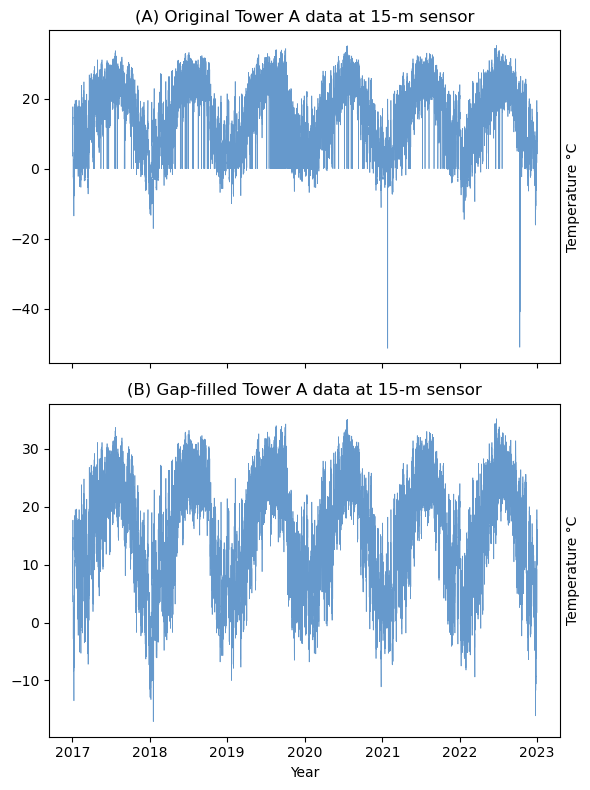

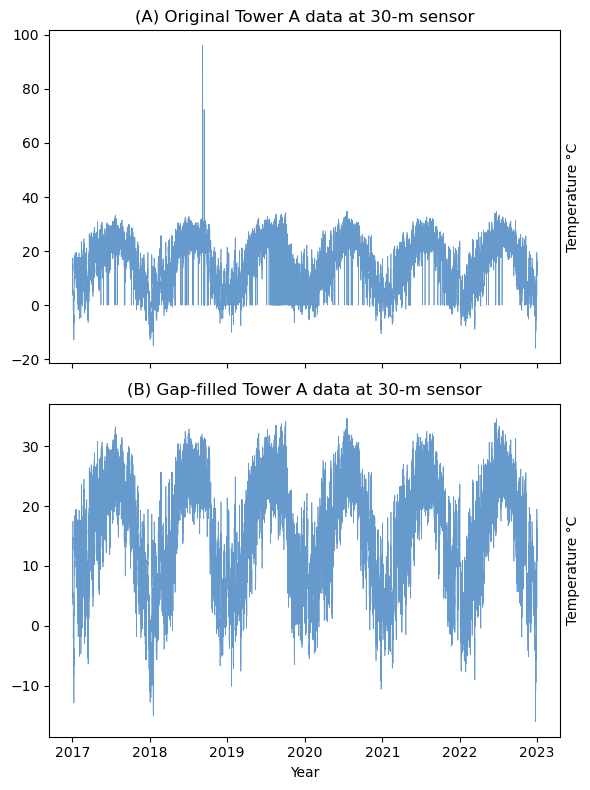

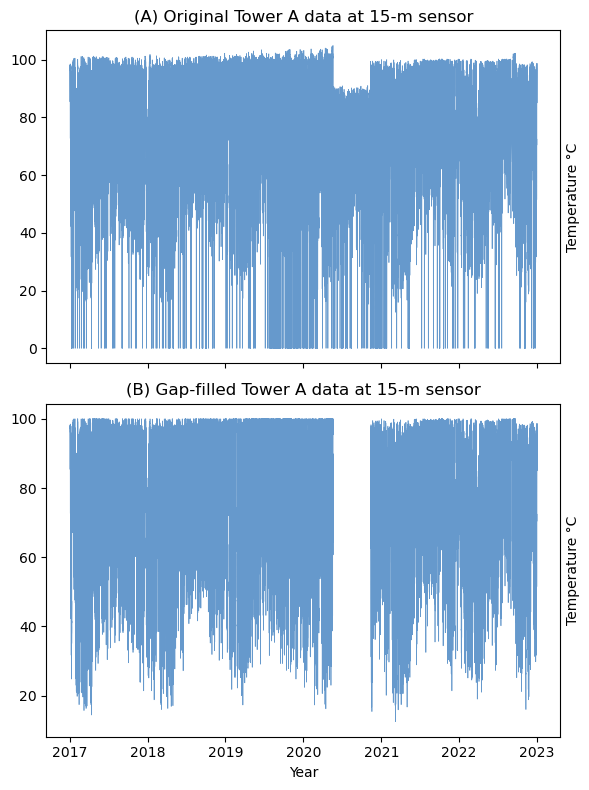

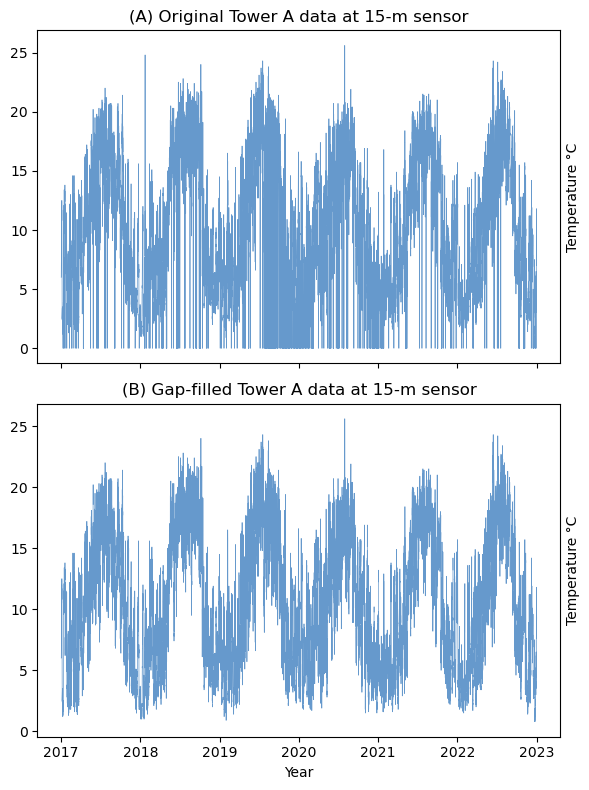

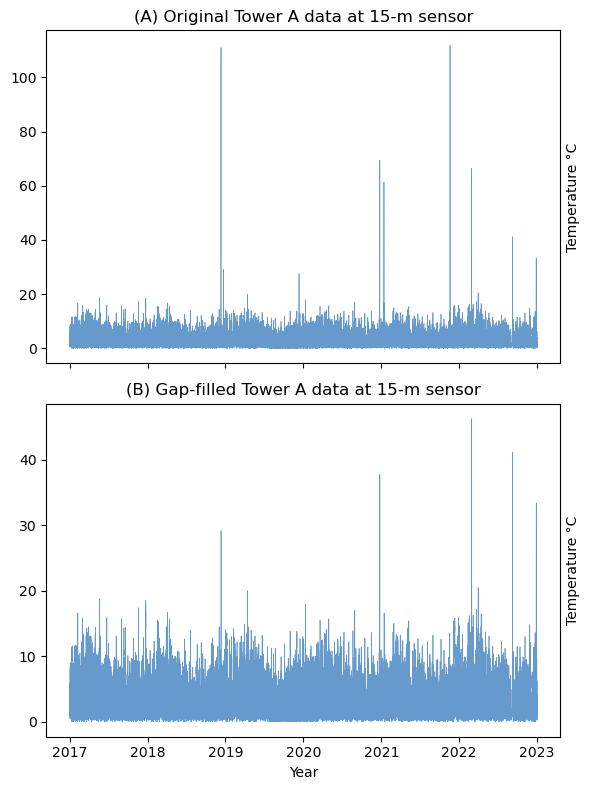

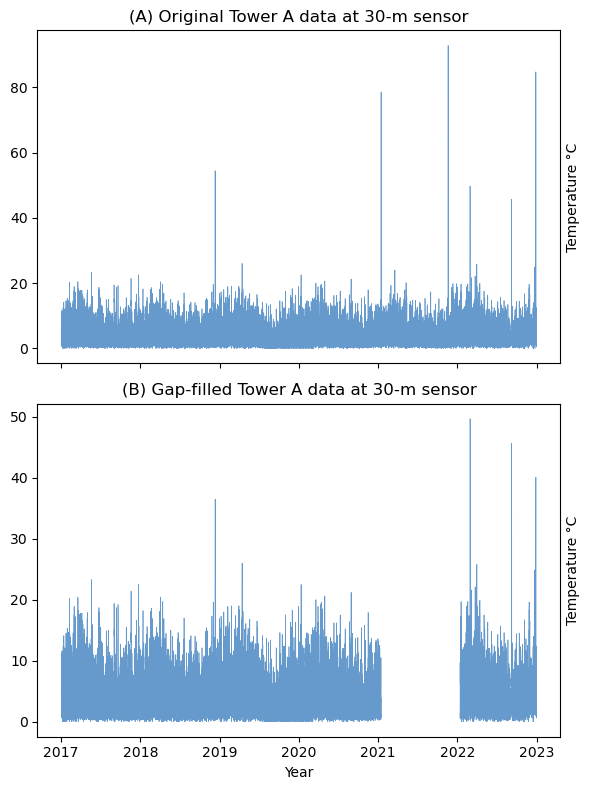

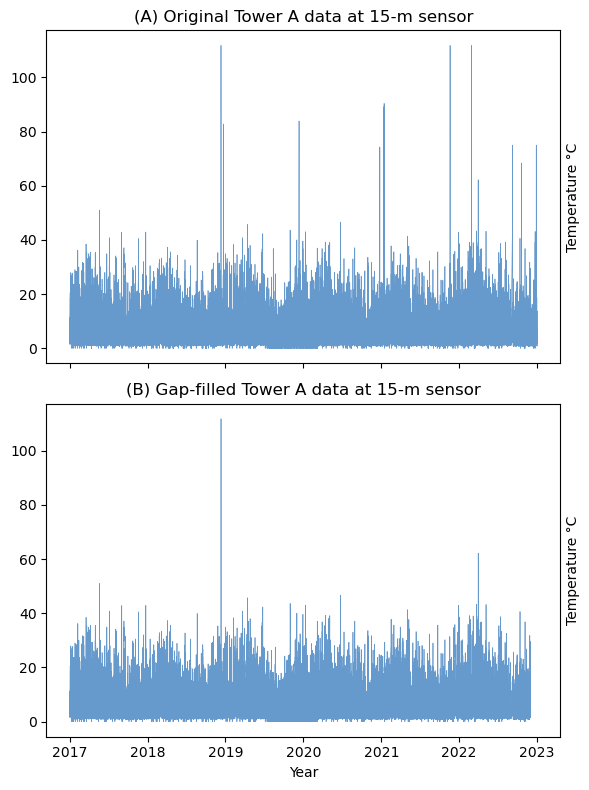

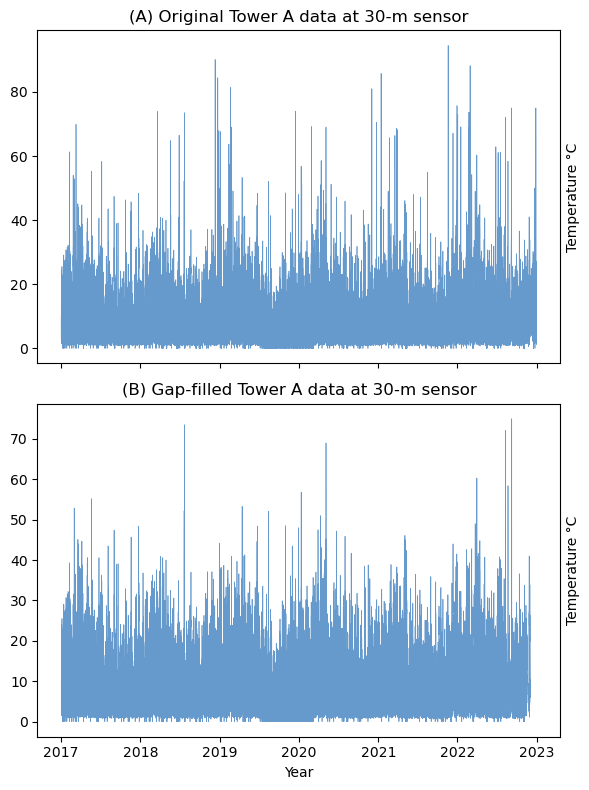

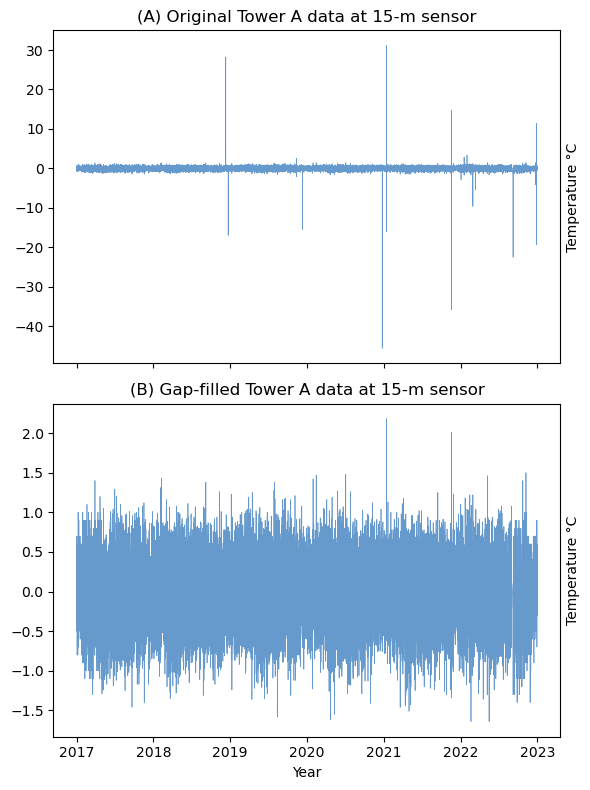

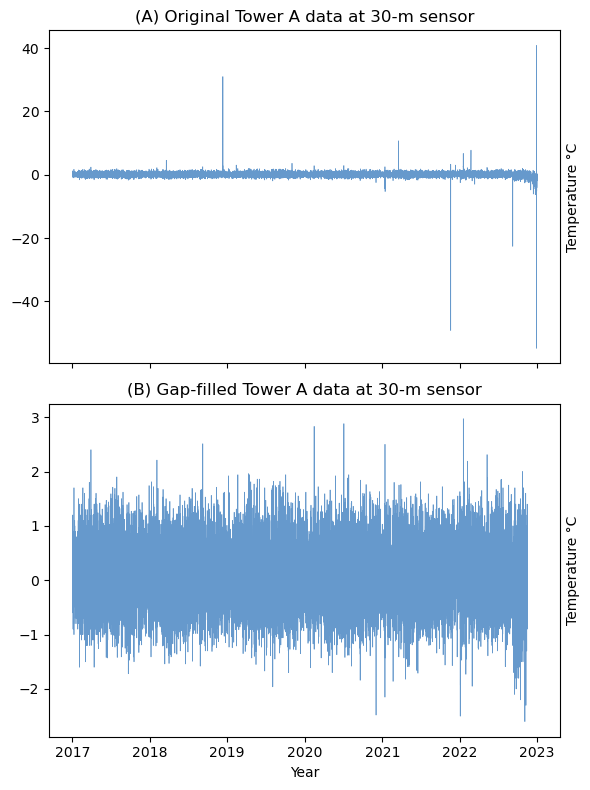

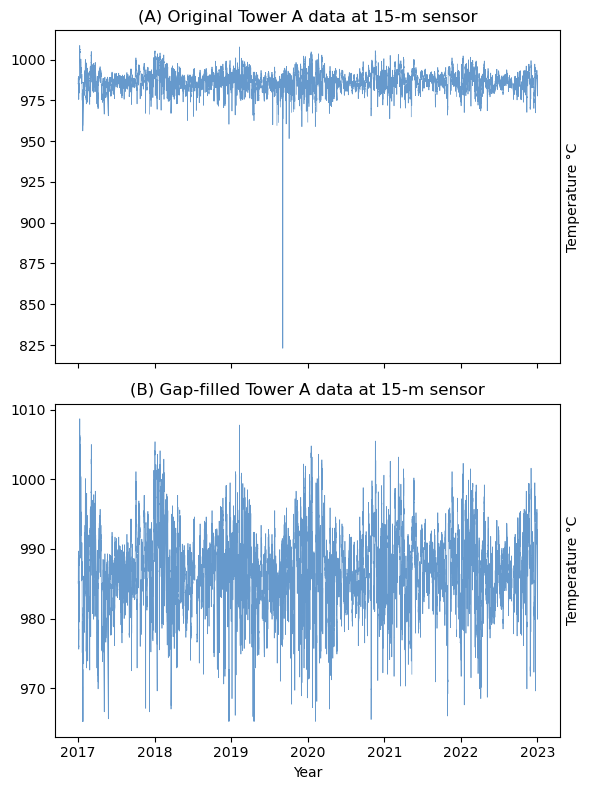

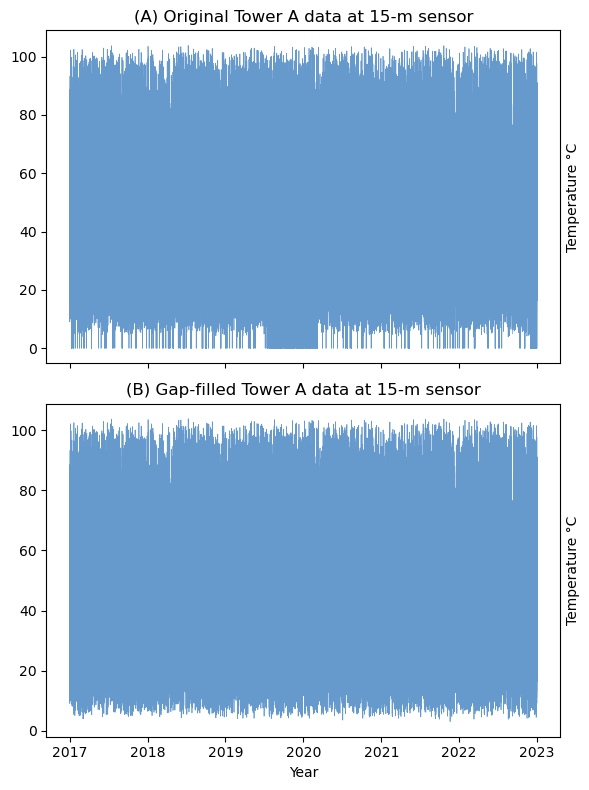

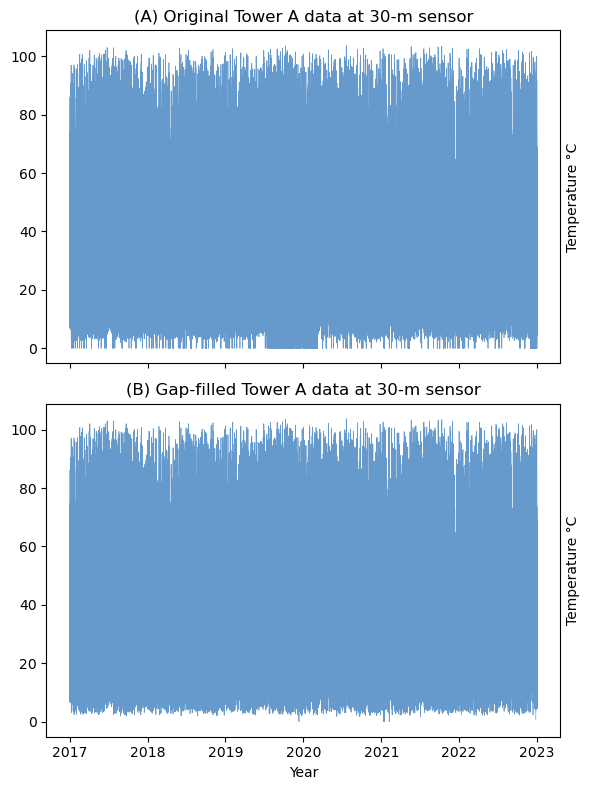

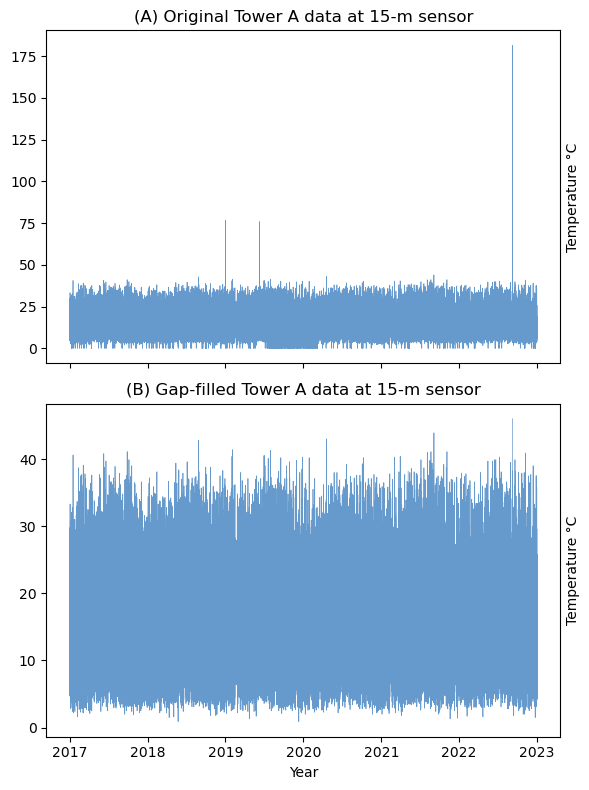

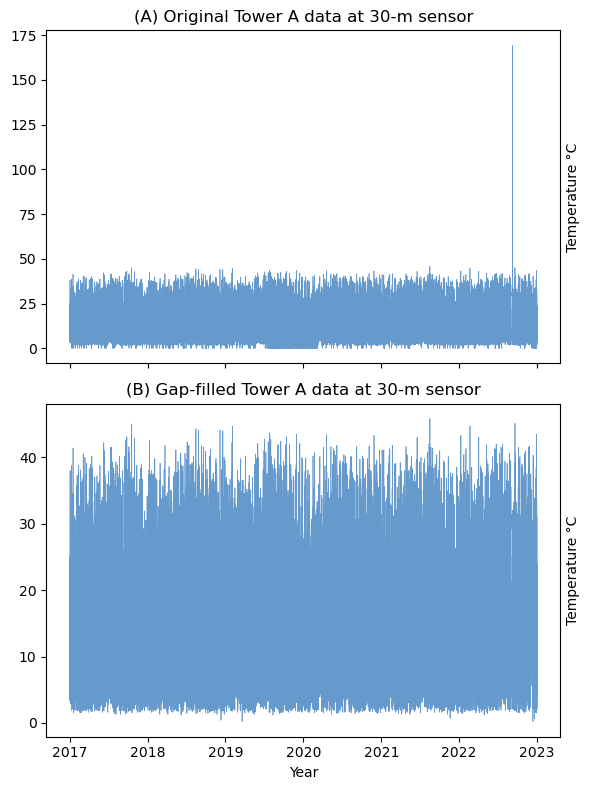

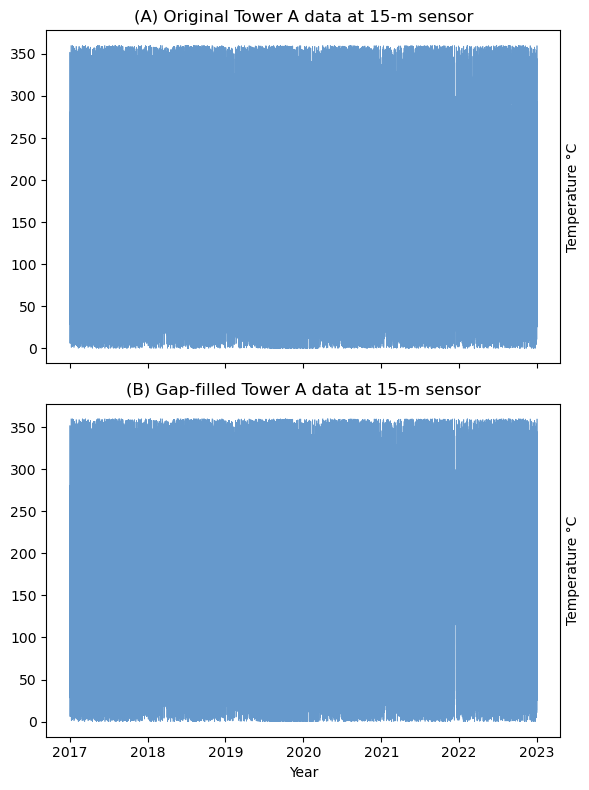

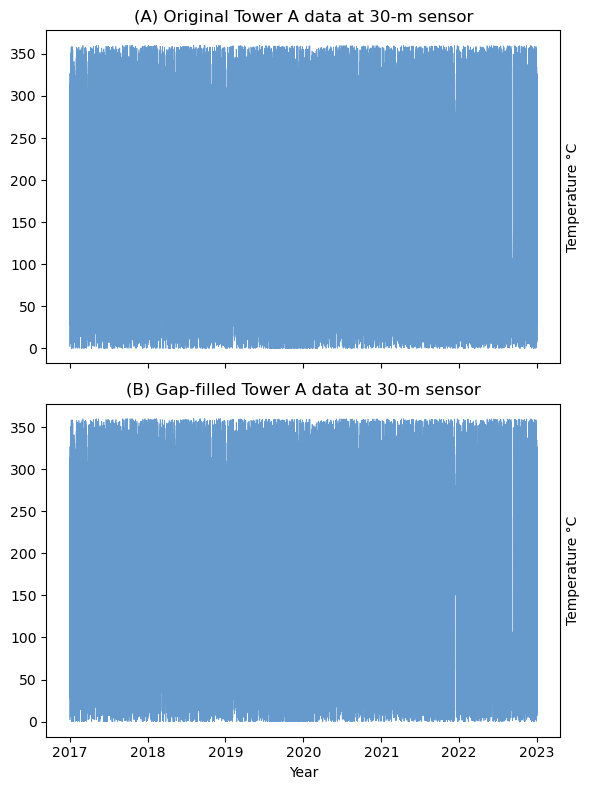

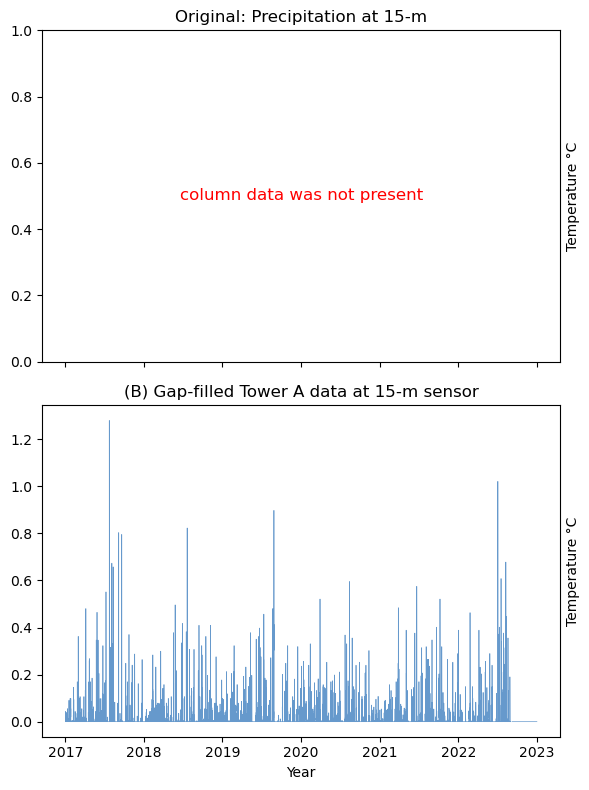

In [88]:
# Ensure a common time column for plotting
time_column = 'UTC_timestamp'  # Adjust this to match your actual time column name
if time_column in gf_df2.columns:
    gf_df2[time_column] = pd.to_datetime(gf_df2[time_column])
if time_column in og_df2.columns:
    og_df2[time_column] = pd.to_datetime(og_df2[time_column])

# Iterate through columns in gf_df (ignoring the time column)
for col in gf_df2.columns:
    if col == time_column:
        continue  # Skip time column
    
    # Start plotting
    fig, axes = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
    
    # Plot from og_df if the column exists, otherwise show placeholder text
    if col in og_df2.columns:
        axes[0].plot(og_df2[time_column], og_df2[col], color=(0.4, 0.6, 0.8), lw=0.5)
        axes[0].set_title(f"(A) Original Tower A data at {col.split(' ')[-1]} sensor")
    else:
        axes[0].text(0.5, 0.5, 'column data was not present', 
                     horizontalalignment='center', verticalalignment='center', 
                     transform=axes[0].transAxes, fontsize=12, color='red')
        axes[0].set_title(f"Original: {col}")
    
    # Plot from gf_df
    axes[1].plot(gf_df2[time_column], gf_df2[col], color=(0.4, 0.6, 0.8), lw=0.5)
    axes[1].set_title(f"(B) Gap-filled Tower A data at {col.split(' ')[-1]} sensor")
    
    # Add labels and finalize formatting
    axes[1].set_xlabel("Year")
    axes[0].set_ylabel("Temperature °C")
    axes[0].yaxis.set_label_position("right")
    axes[1].set_ylabel("Temperature °C")
    axes[1].yaxis.set_label_position("right")
    plt.tight_layout()
    plt.show()

In [91]:
import pandas as pd
import numpy as np
import random

# List of names to check for in column names
names = [
    "DT", "MixHeight", "MixRatio", "SatMixRatio", "SatVaporPres", "SonicTemp", "StabSigPhi", "StabSRDT", 
    "UWind", "VaporPres", "VWDir", "VWind", "WElev", "SWSpdMph", "SWSpdMs", "RWSpdMph", "RWSpdMs", 
    "RSWSpdMph", "RSWSpdMs", "SPkWSpdMph", "SPkWSpdMs", "SWDir", "SVWDir", "SSigma", "DT002m015m", 
    "DT002m035m", "DT002m060m", "DT015m035m", "DT015m060m", "SoilTemp", "Ri015m035m", "Ri015m060m", 
    "Stab", "DeltaTemp", "LHV"
]

# Initialize a dictionary to store the results
results = {}

# Loop through each DataFrame in tdfs_15m_gapfilled_linear
for idx, df in enumerate(tdfs_15m_gapfilled_linear):
    # Dictionary to store random samples for the current DataFrame
    df_samples = {}
    
    # Loop through each column in the DataFrame
    for column in df.columns:
        # Check if the column name contains any string from the names list
        if any(name in column for name in names):
            print(column)
            # Extract non-NaN values from the column
            non_nan_values = df[column].dropna().tolist()
            
            # If there are at least 10 non-NaN values, take a random sample
            if len(non_nan_values) >= 10:
                df_samples[column] = random.sample(non_nan_values, 10)
    
    # Store the samples for the current DataFrame
    if df_samples:  # Only include DataFrames with matching columns
        results[f"DataFrame_{idx}"] = df_samples

# Example: Print or process the results
for df_key, sampled_columns in results.items():
    print(f"{df_key}:")
    for column, samples in sampled_columns.items():
        print(f"  {column}: {samples}")